In [1]:
import json
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# load drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Paths
json_path = "/content/drive/MyDrive/exercicios_inteli/pose_estimation/keypoints.json"
images_folder = "/content/drive/MyDrive/exercicios_inteli/pose_estimation/cow"

with open(json_path, 'r') as f:
    data = json.load(f)

# Filtragem para olhar somente para bovinos
all_cow_annotations = [ann for ann in data['annotations'] if ann['category_id'] == 5]

# Associação dos ids aos nomes dos arquivos
image_id_to_filename = {int(k): v for k, v in data['images'].items()}

In [4]:
# Lista dos nomes dos arquivos de bovinos
image_files = os.listdir(images_folder)

In [53]:
len(all_cow_annotations)

842

Podemos perceber pelo output da célula acima que há bem mais bovinos anotados do que imagens de bovinos do dataset (sabemos que há 200 imagens devido a uma análise visual da pasta de imagens bovinas).

In [54]:
# Pegando somente as annotations relativas às imagens do dataset
cow_annotations = [ann for ann in all_cow_annotations if image_id_to_filename[ann['image_id']] in image_files]
len(cow_annotations)

200

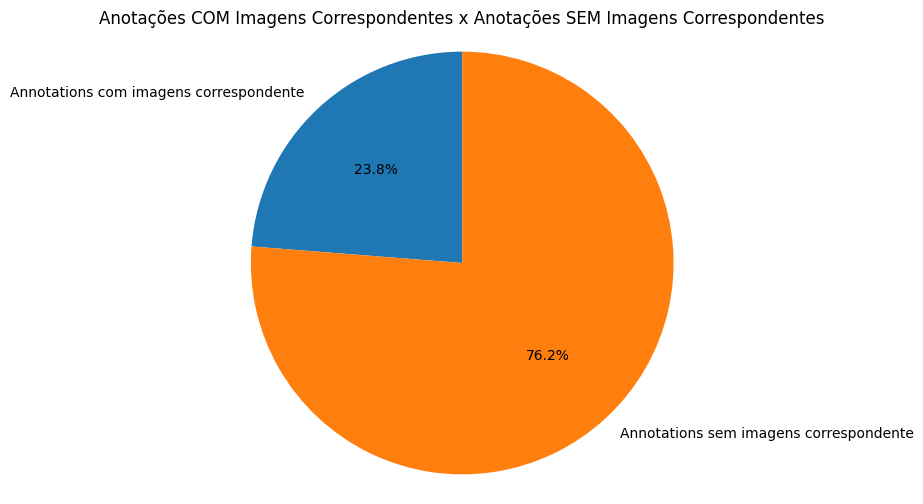

In [57]:
labels = ['Annotations com imagens correspondente', 'Annotations sem imagens correspondente']
sizes = [len(cow_annotations), len(all_cow_annotations) - len(cow_annotations)]

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Anotações COM Imagens Correspondentes x Anotações SEM Imagens Correspondentes')

# Display the chart
plt.show()

Podemos ver que só pegamos 1/4 das imagens anotadas, se fosse um projeto maior, seria interessante ir atrás das outras imagens, para garantir um melhor treinamento do modelo.

In [7]:
# Adicionando o nome do arquivo em cada annotation
for ann in cow_annotations:
    ann['filename'] = image_id_to_filename[ann['image_id']]

In [8]:
# Verificando o resultado final dos nosso annotations
print(cow_annotations[1])

{'image_id': 3810, 'bbox': [31, 16, 249, 212], 'keypoints': [[172, 85, 1], [105, 86, 1], [130, 148, 1], [224, 68, 1], [61, 66, 1], [194, 207, 1], [85, 200, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [149, 196, 1], [0, 0, 0], [0, 0, 0]], 'num_keypoints': 20, 'category_id': 5, 'filename': 'co10.jpeg'}


In [49]:
# Função para carregar a imagem a partir do annotation
def load_image(annotation):
      img_path = os.path.join(images_folder, annotation.get('filename'))
      if os.path.exists(img_path):
          img = cv2.imread(img_path)
          return (img)
      return None

# Função para visualizar os keypoints nas imagens
def plot_keypoints(annotation):
    image = load_image(annotation)
    if image.shape[2] == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')

    for point in annotation['keypoints']:
        if isinstance(point, list) and len(point) == 3:
            x, y, v = point
            if v > 0:
                plt.scatter(x, y, c='r', s=40)

    plt.title("Image with Keypoints")
    plt.axis('off')
    plt.show()

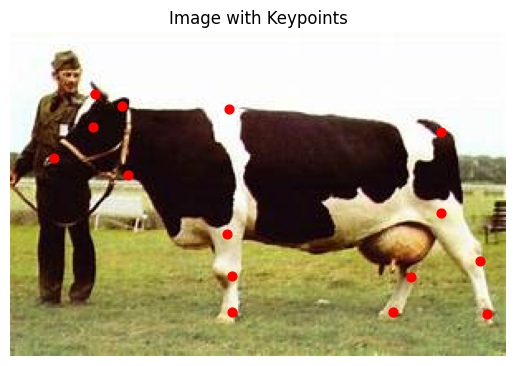

In [10]:
plot_keypoints(cow_annotations[171])

In [11]:
# Função para gerar anotações no estilo yolo
def prepare_yolo_data(data_list, train_dir, val_dir):
    for data in data_list:
        image_id = data['image_id']
        bbox = data['bbox']
        keypoints = data['keypoints']
        num_keypoints = data['num_keypoints']
        filename = data['filename']

        img = load_image(data)
        h, w, _ = img.shape

        x_center = (bbox[0] + bbox[2] / 2) / w
        y_center = (bbox[1] + bbox[3] / 2) / h
        width = bbox[2] / w
        height = bbox[3] / h

        keypoint_annotations = []
        for keypoint in keypoints:
            x, y, visibility = keypoint
            x_rel = x / w
            y_rel = y / h
            keypoint_annotations.extend([x_rel, y_rel, visibility])

        # Lógica para determinar se a imagem vai para train ou val. Aqui fizemos de uma forma bem simplista, onde as 150 primeiras imagens foram usadas para train e as outras 50 para val, garantindo uma divisão train/test de 75/25
        val = False
        if filename[4].isdigit():
            if int(filename[2:4]) >= 15:
              if filename[2:5] != "150":
                output_dir = val_dir
                val = True
        if val == False:
            output_dir = train_dir
        annotation_file = os.path.join(output_dir, f"{filename[:-5]}.txt")
        with open(annotation_file, 'w') as f:
          f.write(f"0 {x_center} {y_center} {width} {height} ")
          f.write(" ".join([str(v) for v in keypoint_annotations]) + "\n")




In [12]:
train_dir = "/content/drive/MyDrive/exercicios_inteli/pose_estimation/dataset/train/labels"
val_dir = "/content/drive/MyDrive/exercicios_inteli/pose_estimation/dataset/val/labels"
prepare_yolo_data(cow_annotations, train_dir, val_dir)

KeyboardInterrupt: 

In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 22.4 MB/s eta 0:00:00


In [37]:
from ultralytics import YOLO

# A escolha do yolov8n-pose foi devido a leveza do modelo em comparação com outros yolo poses.
model = YOLO('yolov8n-pose.pt')

# A decisão de utilizar 50 épocas foi arbitrária, mas outros valores inferiores foram testados, e os resultados não foram bons o suficiente.
results = model.train(data='/content/drive/MyDrive/exercicios_inteli/pose_estimation//dataset/cow_data.yaml', epochs=50)


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/drive/MyDrive/exercicios_inteli/pose_estimation//dataset/cow_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

train: Scanning /content/drive/MyDrive/exercicios_inteli/pose_estimation/dataset/train/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/exercicios_inteli/pose_estimation/dataset/val/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/pose/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.72G      1.828      10.57     0.7034      2.197      2.266         18        640: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         50         50      0.984       0.98      0.994      0.753          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.37G      1.237      10.42     0.7047     0.7842      1.742         17        640: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         50         50      0.999          1      0.995      0.731          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.37G      1.112      10.05     0.7077     0.6485      1.605         14        640: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50         50      0.965          1      0.995      0.724          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.37G      1.076      9.688     0.6897     0.6382      1.595         17        640: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         50         50      0.905       0.94      0.968      0.703          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.37G      1.131      9.273      0.689     0.6871      1.593         21        640: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         50         50      0.892      0.986      0.962      0.737          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.36G      1.036      8.894     0.6843     0.6692      1.565         16        640: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         50         50      0.944       0.96      0.984      0.659          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.44G        1.1      8.718      0.675     0.6635       1.62         20        640: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         50         50      0.846       0.96      0.977      0.703          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.36G      1.055      8.546     0.6619     0.6783      1.513         18        640: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         50         50      0.771      0.874      0.893      0.435          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.44G      1.051      8.429     0.6466     0.6661       1.54         24        640: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         50         50      0.868      0.917      0.927      0.601          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.44G      1.033      8.193     0.6395     0.6799      1.575         18        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50         50      0.784      0.871      0.883      0.502          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.44G      1.053       8.07     0.6314      0.662      1.536         20        640: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         50         50      0.857      0.962       0.95      0.438          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.44G      1.011      7.692     0.6198     0.6882      1.564         20        640: 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         50         50      0.937       0.98      0.989      0.502     0.0243       0.04    0.00228   0.000228



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.44G      1.053      7.573     0.6168     0.6579      1.529         21        640: 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         50         50      0.797        0.9      0.942      0.441     0.0507       0.04    0.00667   0.000667



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.44G      1.099      7.384     0.6102     0.6838      1.596         13        640: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         50         50      0.924       0.96      0.983      0.537       0.01       0.02    0.00104   0.000208



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.44G      1.063      7.403     0.6045     0.6815      1.575         21        640: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50         50      0.943      0.997      0.983      0.676     0.0602       0.08     0.0164    0.00306



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.44G      1.044      6.971     0.5833     0.6625      1.547         22        640: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         50         50      0.996       0.98      0.994      0.805     0.0466       0.04     0.0054   0.000778



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.44G     0.9694      7.034     0.5862     0.6088      1.492         12        640: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50      0.996       0.98      0.994      0.748     0.0941       0.08     0.0191    0.00429



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.44G      1.035       6.56     0.5789     0.6312      1.517         15        640: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         50         50      0.992          1      0.995      0.819     0.0475       0.04    0.00744    0.00324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.44G      0.972      6.819     0.5803     0.6175      1.505         19        640: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         50         50      0.958          1      0.994      0.748     0.0212       0.02    0.00169   0.000169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.44G     0.9562      6.584     0.5687     0.6098      1.455         16        640: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         50         50      0.991          1      0.995       0.75       0.14       0.14     0.0353    0.00512



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.44G     0.9412      6.778     0.5694     0.6117      1.498         16        640: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


                   all         50         50      0.999          1      0.995      0.741     0.0812       0.08     0.0162    0.00321

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.44G     0.9508      6.278     0.5659     0.5848      1.458         22        640: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.998          1      0.995      0.807      0.282       0.22      0.138     0.0237



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.44G     0.9398      6.093      0.567     0.5979      1.496         17        640: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         50         50      0.998          1      0.995      0.816      0.121       0.12     0.0303     0.0062



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.44G      0.874      6.194     0.5541     0.5537       1.41         16        640: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         50         50      0.958          1      0.993      0.764       0.23       0.24      0.112     0.0247



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.44G     0.8849      5.868     0.5498     0.5736      1.418         19        640: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         50         50      0.945          1      0.991      0.786      0.164       0.16     0.0837     0.0175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.44G     0.9052      5.974     0.5444     0.5785      1.431         22        640: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         50         50      0.996          1      0.995      0.829      0.156       0.12     0.0816     0.0134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.44G       0.88       5.76      0.559     0.5361      1.407         18        640: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         50         50      0.997          1      0.995      0.819      0.258       0.16      0.175     0.0256



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.44G     0.8824      5.726     0.5435     0.5591      1.394         16        640: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         50         50      0.997          1      0.995      0.805      0.399        0.4       0.31     0.0475



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.44G     0.8729      5.665     0.5376     0.5593      1.441         18        640: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         50         50      0.997          1      0.995      0.807      0.428        0.4      0.297      0.058



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.44G     0.8381      5.583     0.5395     0.5608      1.387         17        640: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         50         50      0.993          1      0.995      0.804      0.424        0.4      0.239     0.0431



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.44G     0.8752      5.866     0.5312     0.5476      1.409         20        640: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         50         50      0.999          1      0.995      0.813       0.27       0.24     0.0994     0.0191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.44G     0.8158      5.656     0.5395     0.5372      1.344         18        640: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         50         50      0.997          1      0.995      0.821      0.499      0.518      0.367     0.0663



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.44G      0.841      5.509     0.5469     0.5447      1.388         17        640: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         50         50      0.997          1      0.995      0.825      0.479       0.48       0.33     0.0705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.44G     0.8459      5.318     0.5304     0.5572      1.412         22        640: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         50         50      0.998          1      0.995      0.799       0.16       0.16     0.0386    0.00816



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.44G     0.8348       5.24     0.5295     0.5288       1.37         17        640: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.998          1      0.995      0.811        0.5        0.5      0.338     0.0559



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.44G     0.7588      5.263     0.5248     0.4937      1.317         21        640: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         50         50      0.999          1      0.995      0.822      0.559       0.56      0.471      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.44G     0.7831      5.083      0.515     0.5118      1.366         17        640: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         50         50      0.999          1      0.995      0.821      0.519       0.52       0.39     0.0943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.44G     0.7847      5.234     0.5235     0.5031      1.325         17        640: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         50         50      0.999          1      0.995      0.827      0.467       0.46      0.276     0.0598



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.44G     0.7977      4.956     0.5189     0.5322      1.337         14        640: 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         50         50      0.999          1      0.995      0.821      0.568       0.56      0.463      0.125



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.44G     0.7582      4.902     0.5096     0.5037       1.34         19        640: 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         50         50      0.979          1      0.995      0.831      0.664       0.52      0.539      0.126


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.44G      0.736      5.053     0.5687      0.579      1.485          6        640: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         50         50      0.979          1      0.995      0.836      0.567      0.498       0.45      0.115



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.44G     0.5762      4.369     0.5472     0.4183      1.312          6        640: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


                   all         50         50      0.979          1      0.994      0.812      0.431       0.44      0.313      0.049

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.44G     0.5975       4.32     0.5209      0.397      1.311          6        640: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         50         50      0.999          1      0.995      0.811       0.57       0.56       0.51      0.109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.44G     0.5735      4.101     0.5141     0.3645      1.274          6        640: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50         50      0.998          1      0.995      0.818      0.607      0.619      0.544      0.158



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.44G     0.5632      3.945     0.5065      0.356      1.296          6        640: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         50         50      0.999          1      0.995      0.833      0.692        0.5      0.525      0.128



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.44G     0.5767      4.116     0.5016     0.3686      1.295          6        640: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         50         50      0.999          1      0.995      0.829        0.7       0.58       0.59      0.158



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.44G     0.5311      3.856     0.4894     0.3382      1.254          6        640: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         50         50      0.999          1      0.995      0.827      0.678        0.6      0.588      0.163



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.44G     0.5102      3.727     0.4827     0.3403      1.265          6        640: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         50         50      0.999          1      0.995      0.836      0.639       0.64      0.603      0.164



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.44G     0.5177      3.576     0.4782     0.3328       1.23          6        640: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         50         50      0.999          1      0.995      0.828      0.648       0.56      0.528      0.175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.44G     0.5024      3.578     0.4766     0.3309      1.238          6        640: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         50         50      0.999          1      0.995      0.829      0.658        0.6      0.554      0.192



50 epochs completed in 0.069 hours.
Optimizer stripped from runs/pose/train2/weights/last.pt, 7.0MB
Optimizer stripped from runs/pose/train2/weights/best.pt, 7.0MB

Validating runs/pose/train2/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,356,303 parameters, 0 gradients, 9.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


                   all         50         50      0.999          1      0.995      0.827      0.658        0.6      0.554      0.191
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/pose/train2


Teste dos resultados em imagens do dataset de validação.


0: 448x640 1 cow, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


array([[[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[249, 254, 253],
        [249, 254, 253],
        [249, 254, 253],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[247, 252, 251],
        [247, 252, 251],
        [247, 252, 251],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[ 97, 154, 153],
        [ 80, 137, 136],
        [ 89, 148, 144],
        ...,
        [ 78, 147, 144],
        [109, 116, 109],
        [255,  42,   4]],

       [[104, 161, 160],
        [ 86, 143, 142],
        [ 95, 154, 150],
        ...,
        [138, 149, 138],
        [174, 136, 122],
        [255,  42,   4]],

       [[ 96, 153, 152],
        [ 79, 136, 135],
        [ 90, 149, 145],
        ...,
        [255,  42,   4],
        [255,  42,   4],
        [255,  42,   4]]], dtype=uint8)
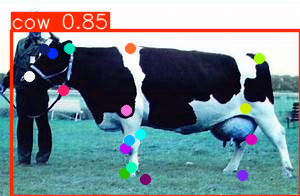

In [47]:
test_image = load_image(cow_annotations[171])
predicted_keypoints = model.predict(test_image)
predicted_keypoints[0].plot()


0: 544x640 1 cow, 14.7ms
Speed: 6.0ms preprocess, 14.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


array([[[164, 238, 232],
        [155, 229, 223],
        [ 85, 159, 155],
        ...,
        [  0,  13,   0],
        [107, 160, 133],
        [154, 208, 179]],

       [[141, 215, 209],
        [101, 175, 169],
        [ 60, 134, 130],
        ...,
        [ 35,  86,  66],
        [ 88, 140, 116],
        [114, 167, 140]],

       [[ 77, 150, 142],
        [ 31, 104,  96],
        [ 58, 130, 124],
        ...,
        [ 75, 127, 109],
        [209, 255, 242],
        [183, 237, 214]],

       ...,

       [[183, 250, 247],
        [ 74, 141, 138],
        [197, 255, 255],
        ...,
        [ 64, 109,  90],
        [ 74, 120,  98],
        [ 30,  78,  54]],

       [[ 83, 156, 154],
        [ 79, 152, 150],
        [117, 184, 185],
        ...,
        [ 64, 114,  96],
        [132, 188, 167],
        [135, 195, 171]],

       [[ 90, 166, 165],
        [102, 176, 176],
        [122, 192, 192],
        ...,
        [ 12,  64,  46],
        [119, 181, 159],
        [129, 194, 172]]], dtype=uint8)
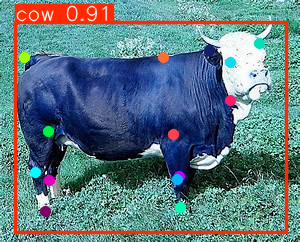

In [50]:
test_image = load_image(cow_annotations[151])
# Predict keypoints
predicted_keypoints = model.predict(test_image)
predicted_keypoints[0].plot()


0: 640x640 1 cow, 14.0ms
Speed: 4.6ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


array([[[237, 200, 156],
        [234, 197, 153],
        [231, 194, 150],
        ...,
        [229, 192, 148],
        [232, 195, 151],
        [235, 198, 154]],

       [[231, 194, 150],
        [228, 191, 147],
        [225, 188, 144],
        ...,
        [224, 187, 143],
        [227, 190, 146],
        [230, 193, 149]],

       [[228, 191, 147],
        [225, 188, 144],
        [222, 185, 141],
        ...,
        [221, 184, 140],
        [224, 187, 143],
        [227, 190, 146]],

       ...,

       [[ 99, 182, 183],
        [106, 189, 187],
        [109, 190, 187],
        ...,
        [ 58, 139, 142],
        [ 62, 145, 147],
        [ 79, 162, 163]],

       [[ 90, 177, 179],
        [101, 187, 187],
        [106, 189, 187],
        ...,
        [ 82, 156, 158],
        [ 94, 169, 171],
        [117, 193, 192]],

       [[ 86, 176, 177],
        [100, 188, 188],
        [107, 191, 189],
        ...,
        [103, 172, 175],
        [115, 187, 187],
        [137, 209, 209]]], dtype=uint8)
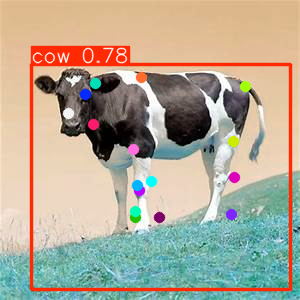

In [51]:
test_image = load_image(cow_annotations[199])
# Predict keypoints
predicted_keypoints = model.predict(test_image)
predicted_keypoints[0].plot()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your training results
csv_path = 'runs/train/exp/results.csv'

# Load the data
data = pd.read_csv(csv_path)

# Plot the desired metrics
plt.figure(figsize=(10, 6))

# For example, plot the training and validation loss over epochs
plt.plot(data['epoch'], data['box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['cls_loss'], label='Classification Loss')
plt.plot(data['epoch'], data['dfl_loss'], label='DFL Loss')  # For object detection tasks

# Add labels and legends
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.show()


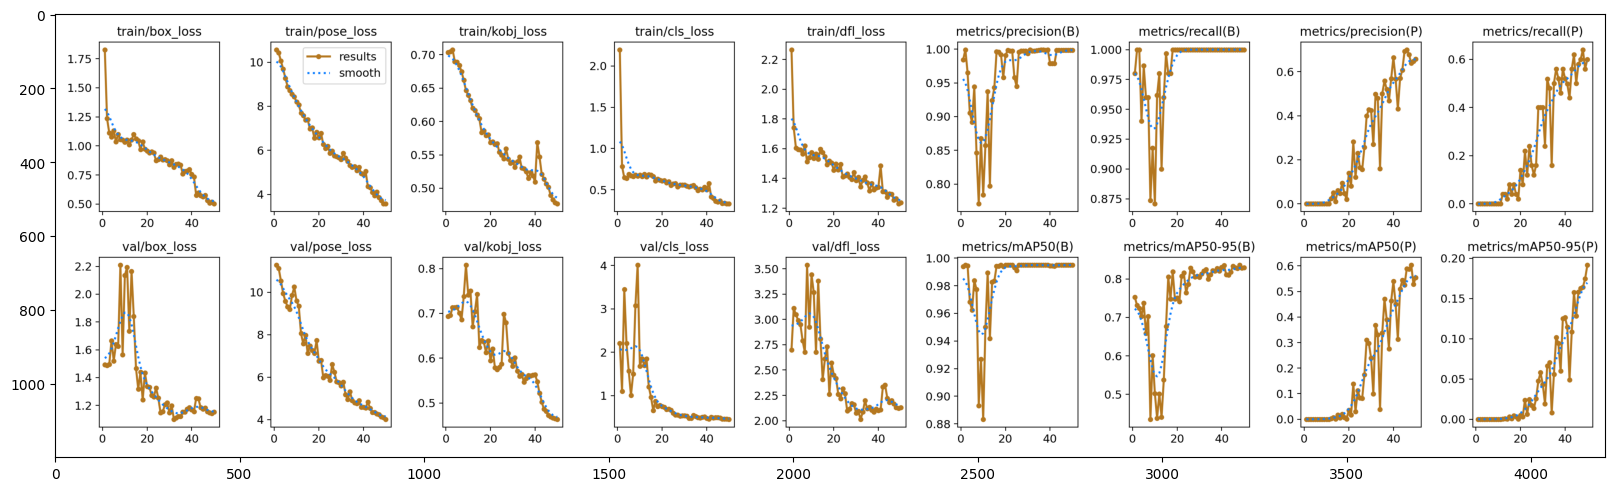

In [65]:
#show image
plt.figure(figsize=(20,20))
plt.imshow(cv2.imread("/content/runs/pose/train2/results.png"))

Olhando para a segunda coluna dos gráficos vemos o loss em pose, e percebe-se que ele seguiu caindo até a época 50, com uma leve redução no declive, mas sem sinais de estagnação definitiva da queda. Isso indica que o modelo poderia ser treinado por mais épocas e provavelmente apresentaria resultados melhores.